In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold


In [2]:
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [3]:
pd.set_option('display.max_columns', 30)

In [4]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,10.0,38600,220.0,CHMT36,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,10.0,28100,220.0,CUFV52,Singapore,-3.16,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,10.0,96400,300.0,ISIG88,Liberia,0.00,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,0.0,700,70.0,MWFU27,Nauru,4.34,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,10.0,19300,180.0,OXZY41,Panama,1.92,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556


In [5]:
test.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE
0,JP,HYG5,Tanker,9.508139,2022-08-27 8:29,R721438,20.0,9,5510,10.0,10.0,3720,100.0,VYRY76,Japan,0.18,0.63,26.8,0.850060,17,97.88,96.49,89.55,766.977634,0.000256
1,SG,GIW5,Container,24.186684,2022-03-27 20:57,G185231,40.0,14,109000,20.0,10.0,94400,330.0,NLTW61,Portugal (Mar),-0.81,-0.77,27.5,1.213528,4,98.14,104.64,100.60,1655.006791,0.002615
2,TW,EKP8,Cargo,0.000000,2023-01-18 2:06,P862781,20.0,14,13700,10.0,10.0,8930,140.0,UVJW25,"China, People's Republic Of",-6.25,-12.57,16.1,6.557436,10,83.70,84.98,79.48,682.595117,0.000427
3,JP,HYG5,Bulk,0.000000,2016-08-02 0:59,B415437,10.0,18,2840,10.0,10.0,1970,80.0,WIPX71,Belize,NaN,NaN,NaN,NaN,9,38.85,41.80,39.51,629.378100,0.000256
4,SG,GIW5,Container,19.834186,2023-01-24 0:27,J412562,30.0,23,30700,20.0,10.0,26000,200.0,ENOX58,Liberia,1.58,-4.47,23.8,3.180123,8,83.88,86.13,80.13,563.101921,0.002615


## 칼럼 정보

```
ARI_CO : 도착항 소속국가(도착항 앞 2글자)
ARI_PO : 도착항의 항구명(도착항 뒤 글자)
SHIP_TYPE_CATEGORY : 선종 통합 바탕으로 5대 선종으로 분류
DIST : 정박지(ber_port)와 접안지 사이의 거리
ATA : anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)
ID : 선박식별 일련번호
BREADTH : 선박의 폭
BUILT : 선박의 연령
DEADWEIGHT : 선박의 재화중량톤수
DEPTH : 선박의 깊이
DRAUGHT : 흘수 높이
G
GT : 용적톤수(Gross Tonnage)값
LENGTH : 선박의 길이
SHIPMANAGER : 선박 소유주
FLAG : 선박의 국적
U_WIND : 풍향 u벡터
V_WIND : 풍향 v벡터
AIR_TEMPERATURE : 기온
BN : 보퍼트 풍력 계급
ATA_LT : anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)
DUBAI : 해당일의 두바이유 값
BRENT : 해당일의 브렌트유 값
WTI : 해당일의 WTI 값
BDI_ADJ : 조정된 벌크운임지수
PORT_SIZE : 접안지 폴리곤 영역의 크기
CI_HOUR : 대기시간(target)
```

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ATA                 367441 non-null  object 
 5   ID                  367441 non-null  object 
 6   BREADTH             367440 non-null  float64
 7   BUILT               367441 non-null  int64  
 8   DEADWEIGHT          367441 non-null  int64  
 9   DEPTH               367440 non-null  float64
 10  DRAUGHT             367440 non-null  float64
 11  GT                  367441 non-null  int64  
 12  LENGTH              367440 non-null  float64
 13  SHIPMANAGER         367441 non-null  object 
 14  FLAG                367441 non-null  object 
 15  U_WIND              213955 non-nul

In [7]:
train.describe()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
count,367441.000000,367440.000000,367441.000000,367441.000000,367440.000000,367440.000000,367441.000000,367440.000000,213955.000000,213955.000000,213076.000000,213955.000000,367441.000000,367441.000000,367441.00000,367441.000000,367441.000000,367441.000000,367441.000000
mean,19.315929,30.550239,14.746082,63588.867056,16.476540,11.086708,41346.606612,205.114468,-0.297587,-0.262955,18.867344,2.706476,11.837903,65.533814,67.55712,63.209494,1348.251333,0.000877,61.877118
std,30.903272,10.957441,7.040392,63558.705308,6.047015,4.600020,39311.578997,75.867383,3.365912,3.735113,9.727090,1.387629,6.645665,20.916641,20.98516,20.630433,738.961048,0.000838,170.575224
min,0.000000,10.000000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,13.520000,19.33000,-37.630000,286.802297,0.000005,0.000000
25%,0.000000,20.000000,10.000000,14400.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.804286,7.000000,50.020000,51.46000,48.360000,836.349201,0.000142,0.000000
50%,6.929929,30.000000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,62.930000,64.62000,59.140000,1187.573732,0.000552,7.949444
75%,25.693063,40.000000,18.000000,81400.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556008,17.000000,76.880000,79.30000,74.250000,1660.987616,0.001614,49.153333
max,199.980651,60.000000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,127.860000,127.98000,123.700000,4795.865609,0.002615,2159.130556


In [8]:
train.describe(include="object")

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,ATA,ID,SHIPMANAGER,FLAG
count,367441,367441,367441,367441,367441,367441,367441
unique,25,103,4,317850,24764,6511,123
top,CN,GIW5,Container,2022-01-31 14:59,E231315,PSPJ35,Panama
freq,132739,41214,155880,49,722,5997,60419


# 데이터 결측지, 이상값 확인

In [9]:
train.isnull().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [10]:
test.isnull().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
SHIPMANAGER                0
FLAG                       0
U_WIND                101927
V_WIND                101927
AIR_TEMPERATURE       102511
BN                    101927
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
dtype: int64

In [11]:
train[train.duplicated(keep=False)]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR


In [12]:
test[test.duplicated(keep=False)]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE


In [13]:
# 결측치 있는 행 제거

train_dropna= train.dropna(axis=0)

In [14]:
test_dropna= test.dropna(axis=0)

In [15]:
train_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213075 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              213075 non-null  object 
 1   ARI_PO              213075 non-null  object 
 2   SHIP_TYPE_CATEGORY  213075 non-null  object 
 3   DIST                213075 non-null  float64
 4   ATA                 213075 non-null  object 
 5   ID                  213075 non-null  object 
 6   BREADTH             213075 non-null  float64
 7   BUILT               213075 non-null  int64  
 8   DEADWEIGHT          213075 non-null  int64  
 9   DEPTH               213075 non-null  float64
 10  DRAUGHT             213075 non-null  float64
 11  GT                  213075 non-null  int64  
 12  LENGTH              213075 non-null  float64
 13  SHIPMANAGER         213075 non-null  object 
 14  FLAG                213075 non-null  object 
 15  U_WIND              213075 non-null  fl

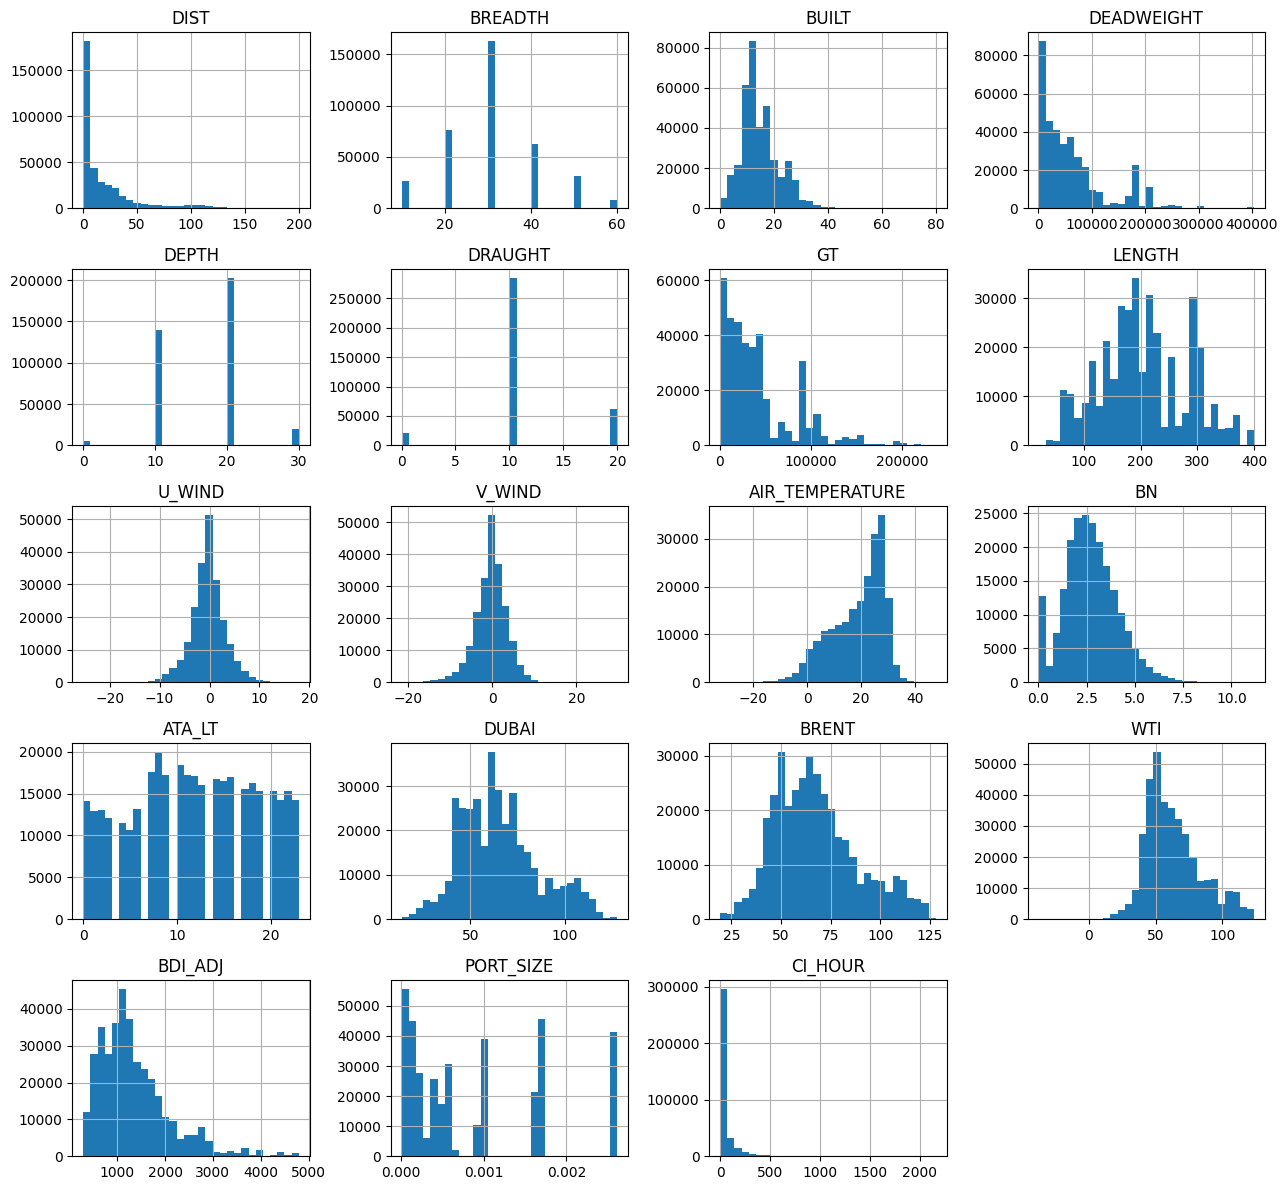

In [16]:
train.hist(figsize=(13, 12),bins=30)
plt.tight_layout()
plt.show()

```
object(카테고리로 변환 하는 게 나을 거 같은 변수들) : BREADTH, DEPTH, DRAUGHT
정규분포를 위한 변환이 필요할 거 같은 변수 : DIST, DEADWEIGHT, GT, AIR_TEMPERATURE, BDI_ADJ
BUILT, BN, WTI은 필요한지 잘 모르겠음...
```

In [17]:
train['BREADTH'] = train['BREADTH'].apply(str)
train['DEPTH'] = train['DEPTH'].apply(str)
train['DRAUGHT'] = train['DRAUGHT'].apply(str)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ATA                 367441 non-null  object 
 5   ID                  367441 non-null  object 
 6   BREADTH             367441 non-null  object 
 7   BUILT               367441 non-null  int64  
 8   DEADWEIGHT          367441 non-null  int64  
 9   DEPTH               367441 non-null  object 
 10  DRAUGHT             367441 non-null  object 
 11  GT                  367441 non-null  int64  
 12  LENGTH              367440 non-null  float64
 13  SHIPMANAGER         367441 non-null  object 
 14  FLAG                367441 non-null  object 
 15  U_WIND              213955 non-nul

In [19]:
from scipy import stats

gt_lambda, lambda_optimal = stats.boxcox(train['GT'])
print(lambda_optimal)

0.29814876640694976


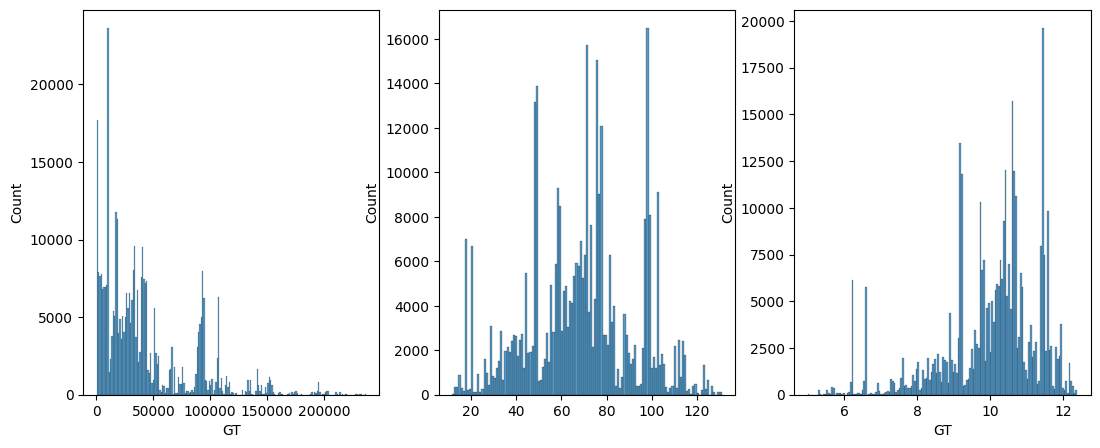

In [20]:
plt.figure(figsize = (13, 5))

plt.subplot(1,3,1)
sns.histplot(train['GT'])
plt.subplot(1,3,2)
sns.histplot(gt_lambda)
plt.subplot(1,3,3)
sns.histplot(np.log(train['GT']))
plt.show()

In [21]:
from scipy import stats

gt_lambda, lambda_optimal = stats.boxcox(train['DEADWEIGHT'])
print(lambda_optimal)

0.2428962051828878


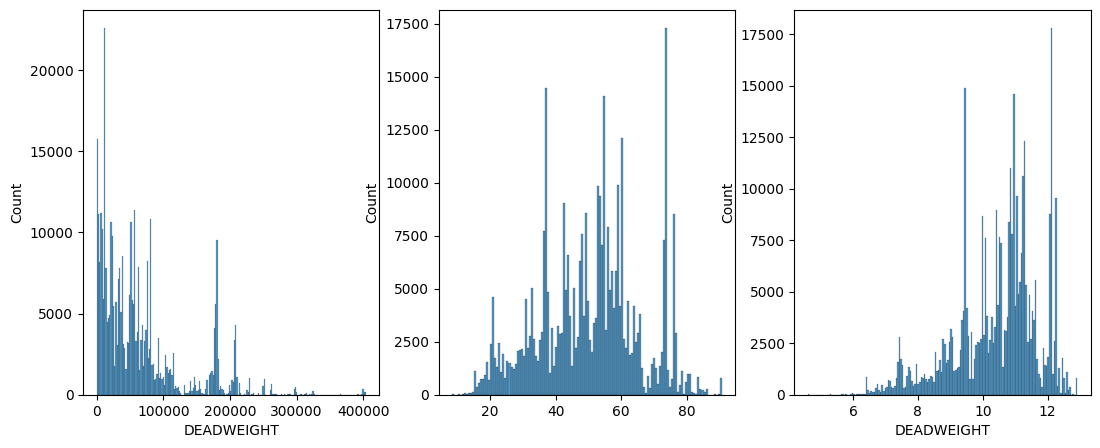

In [22]:
plt.figure(figsize = (13, 5))

plt.subplot(1,3,1)
sns.histplot(train['DEADWEIGHT'])
plt.subplot(1,3,2)
sns.histplot(gt_lambda)
plt.subplot(1,3,3)
sns.histplot(np.log(train['DEADWEIGHT']))
plt.show()

In [23]:
from scipy import stats

gt_lambda, lambda_optimal = stats.boxcox(train['BDI_ADJ'])
print(lambda_optimal)

0.04539837082878007


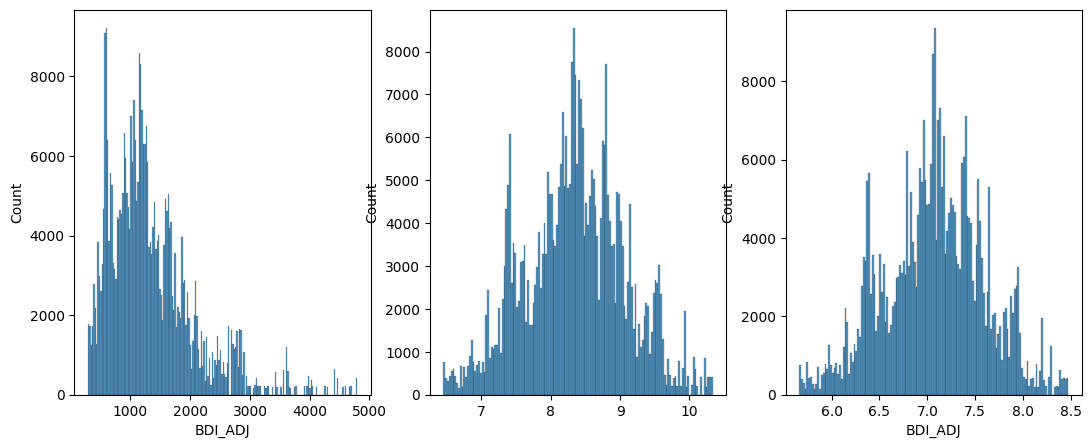

In [24]:
plt.figure(figsize = (13, 5))

plt.subplot(1,3,1)
sns.histplot(train['BDI_ADJ'])
plt.subplot(1,3,2)
sns.histplot(gt_lambda)
plt.subplot(1,3,3)
sns.histplot(np.log(train['BDI_ADJ']))
plt.show()

C:\Users\Seain\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


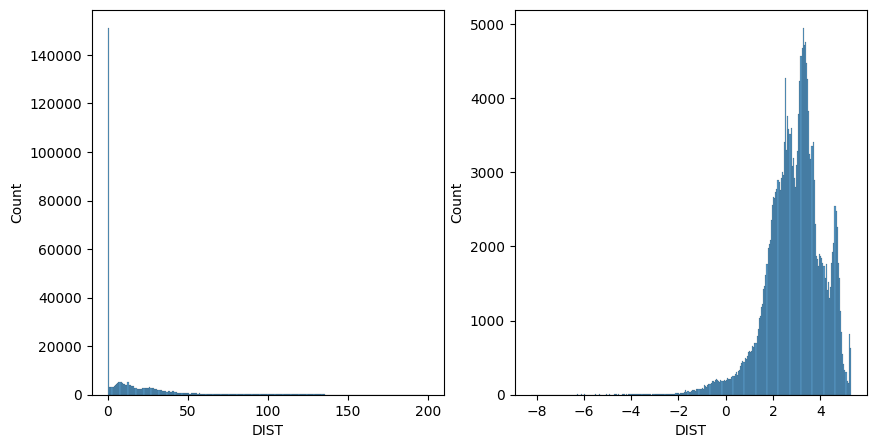

In [25]:
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
sns.histplot(train['DIST'])
plt.subplot(1,2,2)
sns.histplot(np.log(train['DIST']))
plt.show()

C:\Users\Seain\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Seain\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


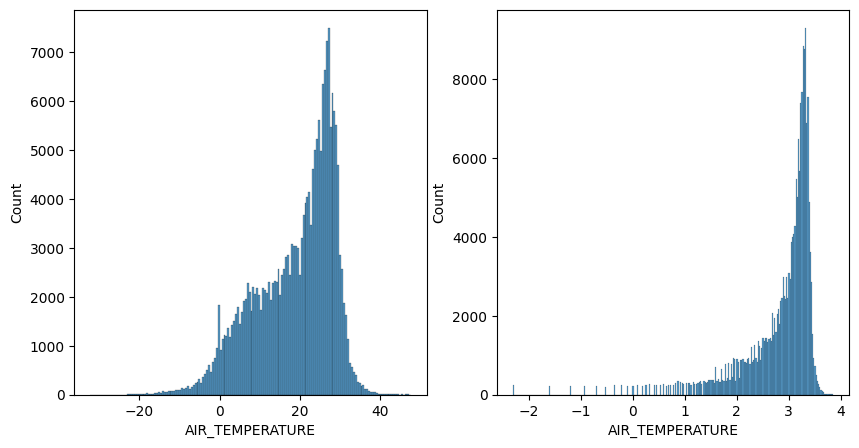

In [26]:
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
sns.histplot(train['AIR_TEMPERATURE'])
plt.subplot(1,2,2)
sns.histplot(np.log(train['AIR_TEMPERATURE']))
plt.show()

## 변환결과
```
BoxCox 변환을 시도한 것 : DEADWEIGHT, GT, BDI_ADJ -> 이중 BDI_ADJ은 로그변환과 큰 차이 X
로그 변환을 시도한 것 : DIST, AIR_TEMPERATURE -> AIR_TEMPERATURE 이상하게 변환됨
```

In [27]:
numeric_feature = train.columns[(train.dtypes==int) | (train.dtypes== float)]
categorical_feature = train.columns[train.dtypes=='O']

print("수치형 데이터 \n", list(numeric_feature))
print("카테고리형 데이터 \n", list(categorical_feature))

수치형 데이터 
 ['DIST', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR']
카테고리형 데이터 
 ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ATA', 'ID', 'BREADTH', 'DEPTH', 'DRAUGHT', 'SHIPMANAGER', 'FLAG']


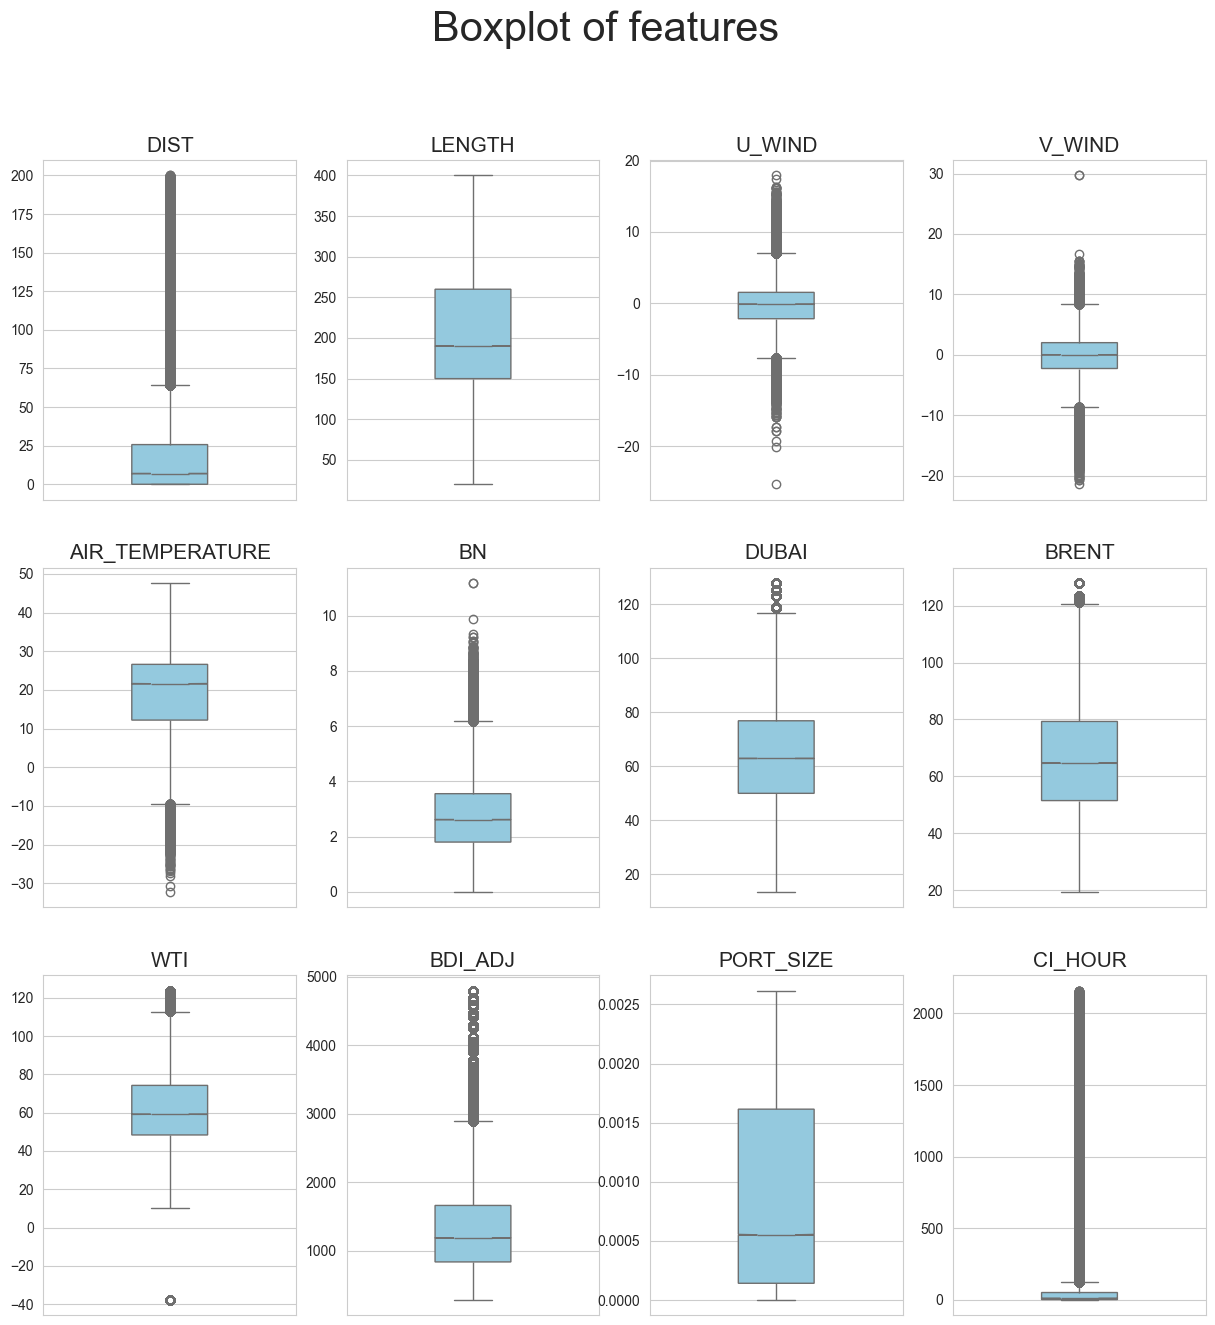

In [29]:
# numeric boxplot 확인

fig, axes = plt.subplots(3, 4, figsize = (15, 15))
fig.suptitle('Boxplot of features', fontsize = 30)
sns.set_style('whitegrid')

column_idx = 0
for i in range(3):
  for j in range(4):
    sns.boxplot(y = train[numeric_feature[column_idx]], notch = True, color = 'skyblue', width = 0.3, ax = axes[i][j]).set_title(numeric_feature[column_idx], fontsize = 15)
    axes[i][j].set_ylabel('')
    column_idx += 1

```
이상값 나오는 featrue : DIST, U_WIND, V_WIND, AIR_TEMPATURE, BN, BRENT, WTI, BDI_ADJ, CI_HOUR

없앨만한 이상값이라 판단 : WTI
```

In [31]:
# WTI 컬럼의 이상치 제거 (IQR*3)

# Q1, Q3 범위 정의
Q1 = train['WTI'].quantile(0.25)
Q3 = train['WTI'].quantile(0.75)
IQR = Q3 - Q1    #IQR 범위. 
rev_range = 1.5  # 제거 범위 조절 변수 설정

# 이상치 범위 설정
filter = (train['WTI'] >= Q1 - rev_range * IQR) & (train['WTI'] <= Q3 + rev_range *IQR)
train_rmv = train.loc[filter]
print(train['WTI'].describe())
print()
print(train_rmv['WTI'].describe())

count    367441.000000
mean         63.209494
std          20.630433
min         -37.630000
25%          48.360000
50%          59.140000
75%          74.250000
max         123.700000
Name: WTI, dtype: float64

count    360007.000000
mean         62.140004
std          19.228353
min          10.010000
25%          48.220000
50%          58.560000
75%          73.300000
max         112.400000
Name: WTI, dtype: float64


In [33]:
train = train_rmv

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360007 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              360007 non-null  object 
 1   ARI_PO              360007 non-null  object 
 2   SHIP_TYPE_CATEGORY  360007 non-null  object 
 3   DIST                360007 non-null  float64
 4   ATA                 360007 non-null  object 
 5   ID                  360007 non-null  object 
 6   BREADTH             360007 non-null  object 
 7   BUILT               360007 non-null  int64  
 8   DEADWEIGHT          360007 non-null  int64  
 9   DEPTH               360007 non-null  object 
 10  DRAUGHT             360007 non-null  object 
 11  GT                  360007 non-null  int64  
 12  LENGTH              360006 non-null  float64
 13  SHIPMANAGER         360007 non-null  object 
 14  FLAG                360007 non-null  object 
 15  U_WIND              206521 non-null  fl

In [36]:
# category type feature 종류 확인
# ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ATA', 'ID', 'BREADTH', 'DEPTH', 'DRAUGHT', 'SHIPMANAGER', 'FLAG']

print(train['ARI_CO'].unique())
print(train['ARI_PO'].unique())
print(train['SHIP_TYPE_CATEGORY'].unique())
print(train['ID'].unique())
print(train['SHIPMANAGER'].unique())
print(train['FLAG'].unique())
print(train['BREADTH'].unique())
print(train['DEPTH'].unique())
print(train['FLAG'].unique())
print(train['FLAG'].unique())

['CN' 'JP' 'RU' 'AU' 'SG' 'ZA' 'KR' 'TW' 'TT' 'ID' 'BR' 'QA' 'LV' 'MZ'
 'US' 'IN' 'UA' 'CA' 'MY' 'PE' 'VN' 'FI' 'CL' 'VE' 'PH']
['EKP8' 'EUC8' 'NGG6' 'TMR7' 'NNC2' 'ZAG4' 'MIA8' 'QYY1' 'WHH4' 'YDP4'
 'KSF1' 'VYJ1' 'GIW5' 'SPG1' 'CXL1' 'BGD2' 'FCD5' 'QQW1' 'JWI3' 'HGH2'
 'IVU2' 'URE2' 'WEY7' 'LXJ7' 'IEW6' 'UVK6' 'MMW5' 'JEN5' 'YRT6' 'VXM8'
 'HYG5' 'NCU8' 'JTD1' 'VFD8' 'AZU6' 'AIB7' 'KIU2' 'TDA5' 'WXQ2' 'MCG4'
 'QEA4' 'OZD2' 'PDL4' 'UIR7' 'QGN3' 'UJM2' 'TMW2' 'WAF5' 'NQO4' 'CEI5'
 'DMD4' 'EVL6' 'XVZ3' 'JER7' 'QTU5' 'XIU1' 'EVX2' 'BAZ5' 'QGL7' 'PPM2'
 'RKA2' 'PEL6' 'LHD1' 'URD4' 'TXO3' 'BGX4' 'FFM2' 'YFK5' 'SLZ5' 'QRN3'
 'EIA2' 'FAV3' 'OKM4' 'OBZ3' 'CSP6' 'PAF4' 'TBL3' 'JGL5' 'TYY2' 'XGX5'
 'UEW5' 'GRQ5' 'HYV6' 'REJ1' 'PUF3' 'SXD2' 'FTQ1' 'PBQ1' 'JDG8' 'MOC5'
 'DEJ2' 'XEO4' 'GQJ7' 'EFG4' 'OOV8' 'UPI6' 'JEA6' 'QXE2' 'DIN2' 'ZME5'
 'ONW1' 'XZF6' 'RGT8']
['Bulk' 'Container' 'Cargo' 'Tanker']
['Z517571' 'U467618' 'V378315' ... 'W812631' 'Q748725' 'D815237']
['CHMT36' 'CUFV52' 'ISIG88' ... 'QZ

In [37]:
# ID와 SHIPMANAGER 종류가 너무 많기 때문에 인코딩 안 하고 제거

train = train.drop(['ID' ,'SHIPMANAGER'],axis=1)
test = test_dropna.drop(['ID' ,'SHIPMANAGER'],axis=1)

In [38]:
train_ohe = pd.get_dummies(train, columns = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'BREADTH', 'DEPTH', 'DRAUGHT'])

In [39]:
train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360007 entries, 0 to 367440
Columns: 166 entries, DIST to DRAUGHT_nan
dtypes: bool(148), float64(12), int64(4), object(2)
memory usage: 103.0+ MB


In [40]:
# ATA 변수 datetime 변수로

train['ATA'] = pd.to_datetime(train['ATA'])
test_dropna['ATA'] = pd.to_datetime(test_dropna['ATA'])

In [41]:
for df in [train, test_dropna]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test_dropna.drop(columns='ATA', inplace=True)

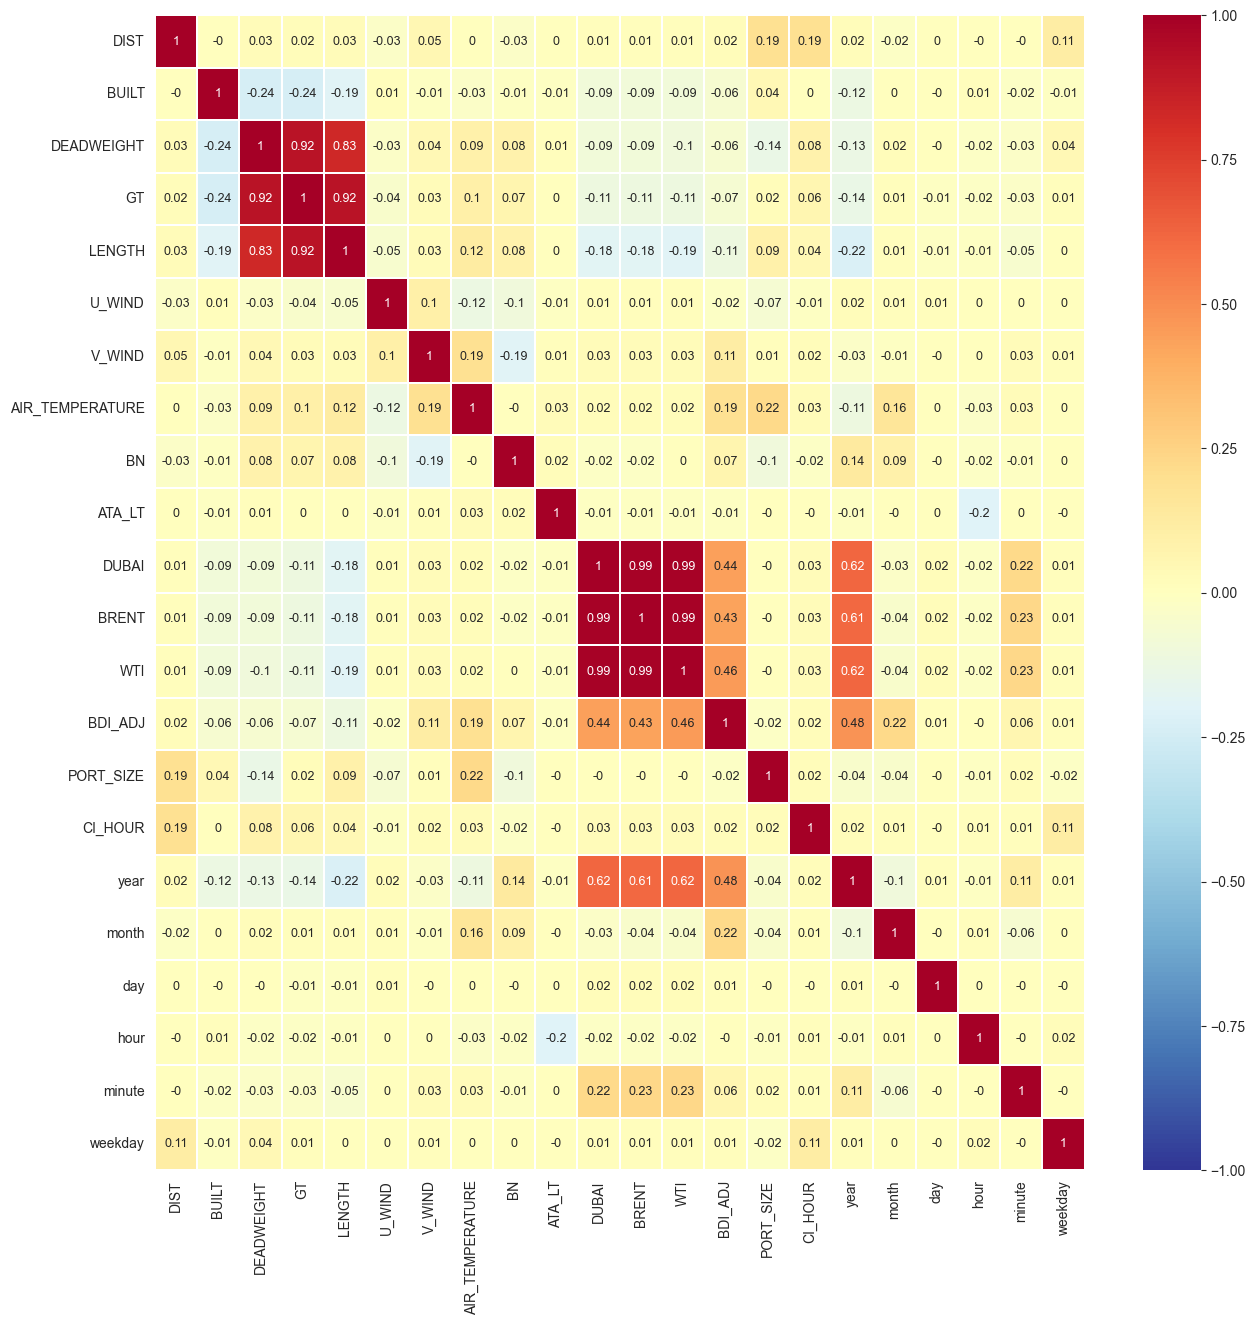

In [42]:
# 상관관계 확인

corr_matrix_pos = (train.corr(numeric_only=True).round(2))

plt.figure(figsize=(15,15))

sns.heatmap(
    data=corr_matrix_pos,
    annot=True,
    annot_kws={'size':9},
    cmap=plt.cm.RdYlBu_r,
    vmin=-1,
    linewidth=.1
)

plt.show()

# 시계열 그래프

In [45]:
train_time = train_rmv

In [46]:
train_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360007 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              360007 non-null  object 
 1   ARI_PO              360007 non-null  object 
 2   SHIP_TYPE_CATEGORY  360007 non-null  object 
 3   DIST                360007 non-null  float64
 4   ATA                 360007 non-null  object 
 5   ID                  360007 non-null  object 
 6   BREADTH             360007 non-null  object 
 7   BUILT               360007 non-null  int64  
 8   DEADWEIGHT          360007 non-null  int64  
 9   DEPTH               360007 non-null  object 
 10  DRAUGHT             360007 non-null  object 
 11  GT                  360007 non-null  int64  
 12  LENGTH              360006 non-null  float64
 13  SHIPMANAGER         360007 non-null  object 
 14  FLAG                360007 non-null  object 
 15  U_WIND              206521 non-null  fl

In [47]:
for df in [train_time]:
    df['ATA_2'] = df['ATA'].str[0:11]

In [48]:
train_time[['ATA', 'ATA_2']]

,ATA,ATA_2
0,2020-10-15 4:03,2020-10-15
1,2019-09-17 2:55,2019-09-17
2,2019-02-23 6:43,2019-02-23
3,2020-09-18 22:06,2020-09-18
4,2022-08-13 12:57,2022-08-13
...,...,...
367436,2017-11-11 22:23,2017-11-11
367437,2022-04-29 2:58,2022-04-29
367438,2022-07-14 7:58,2022-07-14
367439,2020-12-22 10:07,2020-12-22


In [50]:
train_time['ATA'] = pd.to_datetime(train_time['ATA'])

for df in [train_rmv]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

train_time.drop(columns='ATA', inplace=True)

In [51]:
train_time['ATA_2'] = pd.to_datetime(train_time['ATA_2'])

In [52]:
train_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360007 entries, 0 to 367440
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ARI_CO              360007 non-null  object        
 1   ARI_PO              360007 non-null  object        
 2   SHIP_TYPE_CATEGORY  360007 non-null  object        
 3   DIST                360007 non-null  float64       
 4   ID                  360007 non-null  object        
 5   BREADTH             360007 non-null  object        
 6   BUILT               360007 non-null  int64         
 7   DEADWEIGHT          360007 non-null  int64         
 8   DEPTH               360007 non-null  object        
 9   DRAUGHT             360007 non-null  object        
 10  GT                  360007 non-null  int64         
 11  LENGTH              360006 non-null  float64       
 12  SHIPMANAGER         360007 non-null  object        
 13  FLAG                360007 non-nul

In [53]:
train_time_2 = train_time[['ATA_2','CI_HOUR','year','month','day','hour','minute','weekday']]
train_time_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360007 entries, 0 to 367440
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   ATA_2    360007 non-null  datetime64[ns]
 1   CI_HOUR  360007 non-null  float64       
 2   year     360007 non-null  int32         
 3   month    360007 non-null  int32         
 4   day      360007 non-null  int32         
 5   hour     360007 non-null  int32         
 6   minute   360007 non-null  int32         
 7   weekday  360007 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(6)
memory usage: 16.5 MB
